# Prosodical Analysis of Shakespearean Sonnets

## Introduction

The objective of this project is to detect and investigate metrical irregularities and other prosodic patterns in English verse, using both manual and computational methods of analysis. By investigating these patterns, we can achieve a better understanding of how they contribute to the poetry's effect. 

As a case study, I will analyze the corpus of William Shakespeare's sonnets. As one of the greatest poets in the English language, Shakespeare composes poetry with a subtlety, eloquence, and mastery that make his sonnet corpus a fitting subject for study.

In this report, I will first detail my process of scraping and correcting the corpus of Shakespeare's sonnets. Then I will explain how I parsed and scanned the corpus to encode it into a form that is more efficient and convenient for analysis. Finally, I will give some examples of the sorts of analysis that can be done on this corpus.

```{contents}
```

## Initial Setup

We begin by importing various Python libraries that will be used in this project:

In [1]:
# for web scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup

# for data encoding, manipulation, and display
import json
import numpy as np
import pandas as pd
from enum import IntFlag, auto

# for pattern matching
import re

# for syllabification
from eng_syl.syllabify import Syllabel

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency, binomtest
from IPython.display import display, HTML

2024-05-02 16:10:12.322028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We also define some constants that will be used throughout the project:

In [2]:
N = 14 # maximum number of lines in a sonnet
wordchars = re.compile(r'([a-zA-Z\']+)') # regular expression defining word characters
nonwordchars = re.compile(r'([^a-zA-Z\']+)') # regular expression defining non-word characters
syllabifier = Syllabel() # syllabifier used to split word tokens into component syllables

## Scraping the Corpus

The raw corpus of scanned sonnets was obtained from [Chris Aruffo's Prescanned Shakespeare project](http://prescannedshakespeare.aruffo.com/) and is used with the creator's kind permission. This corpus presented itself as ideal for this project because it already contains scansion information for all 154 sonnets.

According to [Aruffo's website](http://prescannedshakespeare.aruffo.com/about/scansion.htm), the corpus text is "based primarily on the First Folio and its punctuation." The spelling of all words is modernized except for "ore", "ere", "nere", "eene", and "tane", which represent monosyllabic equivalents of "over", "ever", "never", "even", and "taken".

Both conceptually and structurally, we divide the corpus into `text` data, representing the actual text of the sonnets, and `scansion` data, representing the corresponding scansion information.
 
We define some functions that we will use to scrape the sonnets from the web and do some preprocessing:

In [3]:
# get all urls to scrape
def get_urls():
    urls = []
    pref = 'http://prescannedshakespeare.aruffo.com/sonnets'
    max_sonnet = 154
    for i in range(0,11):
        start = i*15 + 1
        end = i*15 + 15 if i < 10 else max_sonnet    
        j = 0
        while j < 15 and start+j <= max_sonnet:
            urls.append(f'{pref}/son{start:0>3}-{end:0>3}/son{start+j:0>3}.htm')
            j += 1
    return urls

# process HTML page and extract the text and scansion of the sonnet therein
def process_html(url, N):
    soup = BeautifulSoup(urlopen(url).read().decode())
    # find p element containing the sonnet
    p = soup.code.p
    while p.text == '\xa0':
        p = p.find_next()
    contents = [x.text for x in p.contents if x.text != '' and x.text != '\n']
    scansions = []
    texts = []
    # extract a max of N lines each of scansion and text data from html
    for i in range(max(len(contents), N)):
        if i%2 == 0:
            scansions.append(contents[i].replace('\xa0',' ').replace('\n','').replace('\t','')[6:])
        else:
            texts.append(contents[i].replace('\xa0',' ').replace('\n','').replace('\t','').replace(
                '//','|').replace('/','|').replace('^',' ').replace('*','').replace('??','').rstrip()[6:])
    # remove any extraneous data
    texts = texts[:N]
    scansions = scansions[:N]
    n = len(texts)
    if texts[n-1] == '':
        texts = texts[:n-1]
        scansions = scansions[:n-1]
    return (texts, scansions)

# read foot divisions from text data and mark them in the scansion data
def mark_feet(texts, scansions):
    n = len(texts)
    # add foot marks to scansions
    for i in range(n):
        for j, c in enumerate(texts[i]):
            if c == '|':
                scansions[i] = scansions[i][:j] + c + scansions[i][j+1:]
    # remove extra spaces around foot marks
    for i in range(n):
        k = 0
        for m in re.finditer(pattern=r' \| ', string=texts[i]):
            j = m.start()-k
            k+=1
            texts[i] = texts[i][:j] + texts[i][j+1:]
            scansions[i] = scansions[i][:j] + scansions[i][j+1:]
    return (texts, scansions)

Using these functions, we read each sonnet from the web and split it into `texts` (the actual text of the poem) and `raw_scansions` (the raw marks indicating how the poem should be scanned).

Although the text of the sonnets includes marks indicating division into feet, the scansion does not. We remedy this situation by copying the foot division marks from the text to the scansion.

Finally, we save the raw text and scansion data for each sonnet into a file called `sonnets-original.txt`.

In [4]:
urls = get_urls()
with open('corpus/sonnets-original.txt', 'w') as f:
    for j, url in enumerate(urls):
        (text, raw_scansion) = process_html(url, N)
        (text, raw_scansion) = mark_feet(text, raw_scansion)
        for i in range(len(text)):
            f.write(raw_scansion[i])
            f.write('\n')
            f.write(text[i])
            f.write('\n')
        f.write('\n')

We can then read the corpus from `sonnets-original.txt` into the variables `texts` and `raw_scansions`:

In [5]:
with open('corpus/sonnets-original.txt') as f:
    raw = f.read().split('\n\n')

texts = []
raw_scansions = []

for sonnet in raw:
    s = []
    t = []
    for i, line in enumerate(sonnet.split('\n')):
        if i % 2 == 0:
            s.append(line)
        else:
            t.append(line)
    texts.append(t)
    raw_scansions.append(s)

This diagram illustrates the current structure of the corpus, before any corrections or parsing have been done. Note how the structure is essentially a two-dimensional array, or a list of lists. Each list is annotated with its length, denoted with the variable $n$.

![](diagrams/diagram_texts_preparse.png)

As this diagram shows, `texts` is a list of 154 sonnets. Each sonnet is itself a list of 14 lines, and each line is a string. (The vertical bar `|` marks foot divisions.)

`raw_scansions` has a structure identical to this except that its lowest level consists not of lines but rather of custom scan marks encoding scansion information for the lines in `texts`. These scan marks are aligned with the corresponding text by whitespace. For example, the alternating scansion and text data for the first quatrain of Sonnet 18 looks like this:

In [6]:
for sc, line in zip(raw_scansions[17][:4], texts[17][:4]):
    print(sc)
    print(line)

  ,    |     ,  |   ,    |    , |       ,
Shall I| compare| thee to| a sum|mer's day?
  ,     |   ,    , |      |   ,    ,|
Thou art| more love|ly and| more temp|erate:
  T     T    .    T |        ,|       ,|      ,
Rough winds do shake| the darl|ing buds| of May,
     , |         , |       , |  T    T   .   T
And sum|mer's lease| hath all| too short a date:


## Correcting the Corpus

The raw scan marks in `raw_scansions` will provide the basis for the scansion of the fully parsed corpus. However, they still need to be corrected both manually and automatically, as well as encoded into a more computationally useful format. The following sections detail this process.

### Manual Correction

The scansion of Aruffo's raw corpus is based on a theory of mathematically equal feet, inspired by a similar approach taken by Edgar Allan Poe. Aruffo explains this theory in the article ["Reconsidering Poe's 'Rationale of Verse'"](https://doi.org/10.1111/j.1754-6095.2011.00037.x). Essentially, the theory holds that any line of metrically valid poetry can be scanned into a number of feet that are quantitatively equal in time.

Although Aruffo's theory of prosody is intriguing, I have decided not to use it in this project. Instead, I have opted to follow a more traditional scansion scheme. Since the scan marks in the raw corpus are based on Aruffo's theory, I have applied a series of manual corrections to make the corpus conform more closely to traditional scansion.

The original scansion data uses several different marks to denote stressed syllables: `,`, `_`, `x`, and `T`. Aruffo [defines these marks](http://prescannedshakespeare.aruffo.com/about/marks.htm) as follows:

| Mark | Meaning | 
| --- | --- |
| , | long syllable |
| _ | extended, extra-long syllable |
| x | short stress (where two short syllables create a single stress) |
| T | syllable that is part of a double foot (made up of three long feet)|

All of these marks have been manually standardized into a single stress mark, `,`. Additionally, unusually short or long feet, which are often associated with these marks, have been redistributed into more standard foot divisions. To assist with this task, I consulted [*The Oxford Dictionary of Shakespearean Pronunciation* by David Crystal](https://doi.org/10.1093/acref/9780199668427.001.0001) to gain a better idea of how the lines would be pronounced and scanned in their original context.

Finally, the placement of a few of the scan marks has been standardized to make automatic parsing easier, and a few extraneous scan marks have been removed.

The file `sonnets-handcorrected.txt` contains this manually corrected version of the corpus. We read this hand-corrected version into the variables `text` and `raw_scansions` (after saving copies of the original text and raw scansion data).

In [7]:
# save original scansion and text data
(original_raw_scansions, original_texts) = (raw_scansions, texts)

with open('corpus/sonnets-handcorrected.txt') as f:
    raw = f.read().split('\n\n')

texts = []
raw_scansions = []

for sonnet in raw:
    s = []
    t = []
    for i, line in enumerate(sonnet.split('\n')):
        if i % 2 == 0:
            s.append(line)
        else:
            t.append(line)
    texts.append(t)
    raw_scansions.append(s)

As an example of the manual corrections that have been now been made to the corpus, here is a side-by-side comparison of the original and hand-corrected versions of Sonnet 18. Note how the stress marks and foot divisions have been standardized.

In [8]:
print('ORIGINAL VERSION'.ljust(55, ' '), end='\t\t')
print('HAND-CORRECTED VERSION', end='\n\n')
for sc1, sc2, line1, line2 in zip(original_raw_scansions[17], raw_scansions[17], original_texts[17], texts[17]):
    print(sc1.ljust(55, ' '), end='\t\t')
    print(sc2)
    print(line1.ljust(55, ' '), end='\t\t')
    print(line2)

ORIGINAL VERSION                                       		HAND-CORRECTED VERSION

  ,    |     ,  |   ,    |    , |       ,              		  ,    |     ,  |   ,    |    , |       ,
Shall I| compare| thee to| a sum|mer's day?            		Shall I| compare| thee to| a sum|mer's day?
  ,     |   ,    , |      |   ,    ,|                  		  ,     |   ,    , |      |   ,    ,|
Thou art| more love|ly and| more temp|erate:           		Thou art| more love|ly and| more temp|erate:
  T     T    .    T |        ,|       ,|      ,        		  ,     ,  |       , |        ,|       ,|      ,
Rough winds do shake| the darl|ing buds| of May,       		Rough winds| do shake| the darl|ing buds| of May,
     , |         , |       , |  T    T   .   T         		     , |         , |       , |  ,    ,  |     ,
And sum|mer's lease| hath all| too short a date:       		And sum|mer's lease| hath all| too short| a date:
  T   T   T |  ,     |  T   .   Tx      T              		  ,   , |  ,   , |      , |  .   ,|     

### Automatic Correction

The next step is to make automatic corrections – corrections that can be applied computationally by using algorithms and pattern matching — to the scansion corpus.

The reason that algorithmic corrections are necessary is because of a concept that I refer to as *prosodical flexibility*. In English (and especially in Shakespearean English), certain morphological units can be scanned in different ways depending on the constraints of the meter. For example, consider the word "buried" in Sonnet 31:

In [9]:
for i, line in enumerate(texts[30]):
    if 'buried' in line.replace('|',''):
        print(f'Line {i+1}: {line}')

Line 4: And all| those friends| which I| thought bur|ied.
Line 9: Thou art| the grave| where bur|ied love| doth live,


In line 4, the constraints of the meter encourage us to pronounce the past participle ending "-ed" in the word "buried" as a separate syllable (so the entire word is scanned as three syllables, "bur-i-ed"). In line 9, on the other hand, the "-ed" ending is not pronounced as a separate syllable (so the entire word is scanned as two syllables, "bur-ied").

This past participle ending is thus an example of a morphological unit that is prosodically flexible. Depending on how the rest of the line is scanned, a prosodically flexible unit can either be pronounced as a separate syllable or collapsed into the preceding or following syllables.

As another example, consider the word "heaven" in Sonnet 21:

In [10]:
for i, line in enumerate(texts[20]):
    if 'heaven' in line.replace('|',''):
        print(f'Line {i+1}: {line}')

Line 3: Who heaven| itself| for orn|ament| doth use
Line 8: That heav|en's air| in this| huge rond|ure hems.
Line 12: As those| gold cand|les fixed| in heav|en's air:


In line 3, the word "heaven" is compressed into a single syllable, while in lines 8 and 12, it takes up two syllables. The word "heaven" is thus also prosodically flexible.

These prosodically flexible units are not always marked as such in the raw scansion data. But marking them all by hand would be both inefficient and error-prone. As a result, this is an ideal opportunity to apply automatic correction.

We can use regular expressions — specialized expressions used for pattern matching in strings — to identify patterns of characters that are likely to be prosodically flexible. Then we can add a special scan mark, `?`, to the scansion data for all instances of these patterns to mark them as prosodically flexible. Specifically, this mark will be used to annotate units that can be pronounced as zero or one syllables. In the code, these are referred to as `flex_minus` syllables (because they can be subtracted from the total syllable count as necessary).

Slightly complicating the situation, however, is the fact that we will be using a machine learning model to break apart words (or parts of words) into syllables. This syllabifier does not always recognize prosodically flexible units as separate syllables. For example, the model syllabifies the ending "-ied" into a single syllable rather than two:

In [11]:
syllabifier.syllabify('ied').lower()

'ied'

We cannot simply mark such cases as `flex_minus`. Instead, we will treat them as a separate category of prosodically flexible units that can be pronounced as either one or two syllables. These units will be marked with the symbol `+` and referred to as `flex_plus` in the code (because they can be added to the total syllable count if necessary).

We begin by defining regular expressions for the `flex_minus` and `flex_plus` categories, as well as a function to apply the annotation. For this step, as with the previous one, *The Oxford Dictionary of Shakespearean Pronunciation* served as a valuable reference.

In [12]:
# handle syllables with flexible stress (that is, syllables that can be
# pronounced separately or collapsed into each other depending on the meter)
# (note that we need to specify two offsets so that, if there is already a
# scan mark at the first offset, we can place the new mark at the second offset)

# regex for patterns that tend to be syllabified as multiple syllables but can be collapsed together
# along with two offsets, either of which can be used to mark these syllables as flexible
flex_minus = [
    [re.compile(r'uels?\b'), 0, 1],
    [re.compile(r'ials?\b'), 0, 1],
    [re.compile(r'iars?\b'), 0, 1],
    [re.compile(r'ires?\b'), 0, 2],
    [re.compile(r'ians?\b'), 0, 1],
    [re.compile(r'iest\b'), 0, 1],
    [re.compile(r'ient?\b'), 0, 1],
    [re.compile(r'ienc[ey]\b'), 0, 1],
    [re.compile(r'ying\b'), 0, 1],
    [re.compile(r'eous\b'), 0, 1],
    [re.compile(r'iousl?y?\b'), 0, 1],
    [re.compile(r'uous\b'), 0, 1],
    [re.compile(r'oners?\b'), 0, 2],
    [re.compile(r'erers?\b'), 0, 2],
    [re.compile(r'owers?\b'), 0, 2],
    [re.compile(r'ours?\b'), 0, 2],
    [re.compile(r'ions?\b'), 0, 1],
    [re.compile(r'uals?\b'), 0, 1],
    [re.compile(r'ually\b'), 0, 1],
    [re.compile(r'iers?\b'), 0, 1],
    [re.compile(r'iors?\b'), 0, 1],
    [re.compile(r'ery\b'), 0, 2],
    [re.compile(r'erims?\b'), 0, 2],
    [re.compile(r'erent\b'), 0, 2],
    [re.compile(r'erances?\b'), 0, 2],
    [re.compile(r'ewels?\b'), 0, 2],
    [re.compile(r'ayers?\b'), 0, 2],
    [re.compile(r'erous\b'), 0, 2],
    [re.compile(r'erously\b'), 0, 2],
    [re.compile(r'erate\b'), 0, 2],
    [re.compile(r'e[rn]ings?\b'), 0, 2],
    [re.compile(r'o[rn]ings?\b'), 0, 2],
    [re.compile(r'iven\b'), 0, 2],
    [re.compile(r'\beven\b', re.IGNORECASE), 0, 2],
    [re.compile(r'\bbeing\b', re.IGNORECASE), 1, 2],
    [re.compile(r'\bcreat\|?ure', re.IGNORECASE), 2,3],
    [re.compile(r'\bheaven', re.IGNORECASE), 1,4],
    [re.compile(r'\bspirit\b', re.IGNORECASE), 1,4],
    [re.compile(r'\btowards?\b', re.IGNORECASE), 1,3],
    [re.compile(r'\bthe\s[aeiou]', re.IGNORECASE), 2,4],
    [re.compile(r'\bis it\b', re.IGNORECASE), 3,4],
]

# regex for patterns that tend not to be syllabified as separate but can be expanded into a separate syllable
# along with two offsets, either of which can be used to mark these syllables as flexible
flex_plus = [
    [re.compile(r'[abcdfghijklmnopqrstuvwxyz]ed\b', re.IGNORECASE), 1, 2]
]

def mark_flex(line, scanmarks, patterns, marker):
    for pattern, first_offset, second_offset in iter(patterns):
        it = re.finditer(pattern, line)
        for m in it:
            start = m.start()
            rslen = len(scanmarks)
            if rslen <= start + second_offset:
                scanmarks = scanmarks + (' ' * (start + second_offset - rslen + 1))
            if scanmarks[start + first_offset] == ' ':
                offset = first_offset
            elif scanmarks[start + second_offset] == ' ':
                offset = second_offset
            else:
                offset = -1
            if offset < 0:
                print(f'error: neither offset is available for line', line)
            else:
                scanmarks = scanmarks[:(start + offset)] + marker + scanmarks[(start + offset + 1):]
    return scanmarks

Next, we perform the actual annotation.

In [13]:
# mark the scansion for each flexible syllable with '?'
for s, sonnet in enumerate(texts):
    for l, line in enumerate(sonnet):
        raw_scansions[s][l] = mark_flex(line, raw_scansions[s][l], flex_minus, '?')
        raw_scansions[s][l] = mark_flex(line, raw_scansions[s][l], flex_plus, '+')

Finally, we save this automatically corrected version of the corpus to another file, called `sonnets-autocorrected.txt`.

In [14]:
with open('corpus/sonnets-autocorrected.txt', 'w') as f:
    for s in range(len(texts)):
        for l in range(len(texts[s])):
            f.write(raw_scansions[s][l])
            f.write('\n')
            f.write(texts[s][l])
            f.write('\n')
        f.write('\n')

## Parsing and Scanning the Corpus

Now that we have finished correcting the corpus, we can begin the process of parsing and scanning it into a form that will be more convenient and efficient to work with.

### Division into Metrical Feet

Our first step is to split `text` and `raw_scansions` apart into metrical feet using the following function:

In [15]:
def split_feet(texts, scansions):
    return (
        [[line.split('|') for line in sonnet] for sonnet in texts],
        [[line.split('|') for line in sonnet] for sonnet in scansions]
    )

In [16]:
(texts, raw_scansions) = split_feet(texts, raw_scansions)

The two-dimensional `texts` and `raw_scansions` arrays have now become three-dimensional, since each line is now a list of feet. The corpus is now a list of 154 sonnets, each of which is a list of 14 lines, each of which is a list of 4 or 5 feet, each of which is a string. (The number of feet is variable because Sonnet 145 is in tetrameter.)

The diagram below illustrates this updated corpus structure for `texts`.

![](diagrams/diagram_texts_feet.png)

### Tokenization

Next, we split each foot in `texts` into separate *tokens* (a process known as *tokenization*). In natural language processing, a token is a semantically distinct unit of text. For the purposes of this study, a token is either a *word token* consisting of any number of consecutive alphabetic characters (and possibly apostrophes) or a *non-word token* consisting of any number of punctuation marks, spaces, and other non-alphabetic characters.

We tokenize the text using the following function:

In [17]:
def tokenize(sonnet, wordchars):
    tokens = [None for i in sonnet]
    for i in range(len(sonnet)):
        feet = []
        for foot in sonnet[i]:
            feet.append([token for token in re.split(pattern=wordchars, string=foot) if token != ""])
        tokens[i] = feet
    return tokens

In [18]:
texts = [tokenize(sonnet, nonwordchars) for sonnet in texts]

The three-dimensional `texts` array has now become four-dimensional, since each foot is now a list of tokens. Each array is a list of 154 sonnets, and each sonnet is a list of 14 lines. Each line is a list of 4 or 5 feet, and each foot is a list of tokens of variable length. Note that the structure of `raw_scansions`, however, has not changed.

The diagram below illustrates this updated corpus structure for `texts`.

![](diagrams/diagram_texts_tokens.png)

### Syllabification

Next, we split the word tokens apart into separate syllables using a GRU-based neural network model from the [`eng-syl` project](https://pypi.org/project/eng-syl/). The model was trained on [Wikimorph data](https://link.springer.com/chapter/10.1007/978-3-030-78270-2_72) and is intended for use as an English syllabifier.

Although the model performs reasonably well on our sonnet corpus, it makes some obvious errors. For example, it syllabifies the word "anew" as one syllable instead of two:

In [19]:
syllabifier.syllabify('anew').lower()

'anew'

Many of these errors happen in cases where the model is being asked to syllabify parts of words rather than entire words. This occurs because we are syllabifying tokens rather than words, and some words have been broken up into multiple tokens (for example, because they cross foot boundaries or contain hyphens).

For example, the model struggles to correctly syllabify the token "ny", which occurs as a part of words such as "many":

In [20]:
syllabifier.syllabify('ny').lower()

'n-y'

We can identify and correct many of these syllabification errors using the regular expressions defined below. Once again, *The Oxford Dictionary of Shakespearean Pronunciation* served as a reference for this process.

In [21]:
syl_corrections = [
    [re.compile(r'^(what)(ere)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(so)(ev)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ob)(se)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(cell)(ent)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(qui)(ty)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(a)(new)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(in)(her)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ist)(er)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(form)(edst)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ann)(y)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(aint)(y)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(imp)(ed)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(qui)(e)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ann)(ous)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(who)(ev)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(per)(pe)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(a)(cy)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(in)(ate)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(grac)(ious)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ti)(cate)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(in)(ar)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(wher)(ev)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ic)(es)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ac)(cus)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ac)(le)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(a)(chieve)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(fic)(es)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ic)(at)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ic)(le)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(pen)(ance)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(an)(ny)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ac)(cum)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^([ai]c)(y)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(ic)(ine)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(who)(ere)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(re)(ve)$', re.IGNORECASE), r'\1-\2'],
    [re.compile(r'^(tre)-(as)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(n)-(a)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(e)-(a)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(a)-(c)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(ri)-(age)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(i)-(l)-(l)(a)$', re.IGNORECASE), r'\1\2\3-\4'],
    [re.compile(r'^(n)-(y)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(u)-(t)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(re)-(as)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(tir)-(ed)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(pho)-(en)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(a)-(c)(quian)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(i)-(c)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(di)-(v)-(id)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(a)-(d)-(d)(i)$', re.IGNORECASE), r'\1\2\3-\4'],
    [re.compile(r'^(he)-(res)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(to)-(r)-(ies)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(e)-(x)-(trem)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(be)-(lov)-(ed)$', re.IGNORECASE), r'\1-\2\3'],
    [re.compile(r'^(se)-(c)-(rate)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(in)-(cre)-(as)$', re.IGNORECASE), r'\1-\2\3'],
    [re.compile(r'^(a)-(di)-(eu)$', re.IGNORECASE), r'\1-\2\3'],
    [re.compile(r'^(lo)-(m)-(el)$', re.IGNORECASE), r'\1-\2\3'],
    [re.compile(r'^(e)-(n)-(ance)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(de)-(s)-(pis)$', re.IGNORECASE), r'\1\2-\3'],
    [re.compile(r'^(ti)-(red)$', re.IGNORECASE), r'\1\2'],
    [re.compile(r'^(de)-(si)-(red)$', re.IGNORECASE), r'\1-\2\3'],
    [re.compile(r'^(pe)-(t)-(u)-(al)$', re.IGNORECASE), r'\1\2-\2-\3'],
    [re.compile(r'^(e)-(x)(pi)-(red)$', re.IGNORECASE), r'\1\2-\3\4'],
]

We can use the following functions to perform the actual syllabification, checking for and correcting the errors along the way:

In [22]:
def syllabify(token, syllabifier):
    # syllabify token with apostrophes removed
    syllabified = syllabifier.syllabify(token.lower().replace('\'', ''))
    # manually correct certain syllabifications
    for pattern, replacement in syl_corrections:
        syllabified = pattern.sub(replacement, syllabified)
    # split syllables into list
    syllabified = syllabified.split('-')
    # use syllabified to separate the original token into syllables
    syls = []
    n = len(syllabified)
    start = end = 0
    for i in range(n):
        if i == n-1:
            syls.append(token[start:])
        else:
            end = start + len(syllabified[i])
            syls.append(token[start:end])
            start = end
    return syls

def syllabify_foot(foot, syllabifier, nonwordchars):
    newfoot = []
    for token in foot:
        if not re.match(nonwordchars, token):
            newfoot += syllabify(token, syllabifier)
        else:
            newfoot.append(token)
    return newfoot

In [23]:
for sonnet in texts:
    for line in sonnet:
        for j, foot in enumerate(line):
            line[j] = syllabify_foot(foot, syllabifier, nonwordchars)

Each word token has now been split into separate syllables (which are each considered a word token). As a result, each foot is now a list of syllables and non-word tokens, listed in the order in which they occur in the original text.

The diagram below shows these changes to the corpus. Note the dimensions of `texts` have not changed; the only change is that some of the feet lists have become longer because their component word tokens have been broken up into syllables.

![](diagrams/diagram_texts_syl.png)

### Scansion

The next step is to parse the raw scansion marks into a more usable and efficient form. The goal is to encode the scansion information into a form that is efficient and easy to store and analyze.

With this in mind, I have chosen to use *bitwise flags* to encode the scansion information. Bitwise flags are variables where each bit corresponds to a Boolean value (true or false). Because these Booleans are encoded at the bit level, this allows us to compactly store information. Additionally, we can work efficiently with these values by using *bitwise operations* that are designed to operate at the bit level.

For this project, we will use Python's built-in `IntFlag` class, which allows us to define enumerated constants that can be combined into bitwise flags and have integer values. We define our `Scansion` class as follows:

In [24]:
class Scansion(IntFlag):
    UNSPEC = 0 # unspecified/unknown
    SYL = 1 # syllable from a word token
    STR = 2 # stressed syllable
    # flexible syllable that can be collapsed into the preceding or following syllable (treated as one or zero syllables)
    FLEX_MINUS = 4
    # flexible syllable that can be expanded into two syllables (can be treated as one or two syllables)
    FLEX_PLUS = 8
    PUNCT = 16 # token that contains punctuation
    HYPHEN = 32 # token that is a single hyphen
    SPACE = 64 # token that contains a space

This class allows us to record information not only about stress but also about token type (syllabic, containing spaces, containing punctuation, etc.).

Note that each constant in `Scansion` has both a name and an associated integer value. For example, `Scansion.SYL`, which represents a token that is syllabic (i.e. a word token), has the value `1`. Meanwhile, `Scansion.STR`, which represents a token that is stressed, has the value `2`.

In [25]:
print(f'Scansion.SYL: {Scansion.SYL} ({bin(Scansion.SYL)[2:]} in binary)')
print(f'Scansion.STR: {Scansion.STR} ({bin(Scansion.STR)[2:]} in binary)')

Scansion.SYL: 1 (1 in binary)
Scansion.STR: 2 (10 in binary)


As the name `IntFlag` implies, we can combine these constants with bitwise operations. For example, using the bitwise operator `|`, we can combine the constants `Scansion.SYL` and `Scansion.STR` into a new `Scansion` value that denotes that a token is both syllabic and stressed. Note how the resultant value `3` is created by combining the individual bits of the component constants.

In [26]:
print(f'Scansion.SYL | Scansion.STR: {Scansion.SYL | Scansion.STR} ({bin(Scansion.SYL | Scansion.STR)[2:]} in binary)')

Scansion.SYL | Scansion.STR: 3 (11 in binary)


Having defined our `Scansion` constants, we can use the following functions to parse the raw scan marks for each token and determine the corresponding `Scansion` value.

In [27]:
def scan_token(token, scanmarks, nonwordchars):
    scansion = Scansion.UNSPEC # unspecified value by default
    if re.search(nonwordchars, token):
        # token is non-syllabic
        if re.search(r'[^\w\s]', token):
            scansion |= Scansion.PUNCT # token contains punctuation
        if token == '-':
            scansion |= Scansion.HYPHEN # token is a single hyphen
        if ' ' in token:
            scansion |= Scansion.SPACE # token contains a space
    else:
        # token is syllabic
        scansion |= Scansion.SYL
        if ',' in scanmarks:
            scansion |= Scansion.STR # token is stressed
        if '?' in scanmarks:
            scansion |= Scansion.FLEX_MINUS # token stress belongs to flex_minus category
        if '+' in scanmarks:
            scansion |= Scansion.FLEX_PLUS # token stress belongs to flex_plus category
    return scansion

def scan_tokens(texts, raw_scansions, nonwordchars):
    scansions = []
    for sonnet, raw_sonnetscan in zip(texts, raw_scansions):
        sonnetscan = []
        for line, raw_linescan in zip(sonnet, raw_sonnetscan):
            linescan = []
            for i, foot in enumerate(line):
                footscan = []
                raw_footscan = raw_linescan[i]
                start = 0
                for token in foot:
                    end = start + len(token)
                    footscan.append(scan_token(token, raw_footscan[start:end], nonwordchars))
                    start = end
                linescan.append(footscan)
            sonnetscan.append(linescan)
        scansions.append(sonnetscan)
    return scansions

We store our custom `Scansion` data in the new variable `scansions`.

In [28]:
scansions = scan_tokens(texts, raw_scansions, nonwordchars)

This new variable `scansions` has a four-dimensional structure identical to that of `texts`, except that the lowest level encodes `Scansion` values instead of tokens. The diagram below illustrates what this looks like. (The values in parentheses are the numerical values of the `Scansion` flags.)

![](diagrams/diagram_scansion_final.png)

We run a quick sanity test to make sure that every token in `text` now has corresponding information in `scansion`.

In [29]:
# sanity test
for sonnet, sonnetscan in zip(texts, scansions):
    assert(len(sonnet) == len(sonnetscan))
    for line, linescan in zip(sonnet, sonnetscan):
        assert(len(line) == len(linescan))
        for foot, footscan in zip(line, linescan):
            assert(len(foot) == len(footscan))

Finally, we save the parsed `texts` and `scansions` data to files called `parsed_texts.txt` and `parsed_scansions.txt`, respectively. For convenient storage, we convert the scansion data into integers and encode both `texts` and `scansions` into the JSON format.

In [30]:
# convert Scansion values into integers for storage
scansions = [[[[
    scansion.value for scansion in foot
] for foot in line] for line in sonnet] for sonnet in scansions]

with open('corpus/parsed_texts.txt', 'w') as f:
    f.write(json.dumps(texts))
with open('corpus/parsed_scansions.txt', 'w') as f:
    f.write(json.dumps(scansions))

## Analyzing the Corpus

We now have a parsed corpus of Shakespeare's sonnets with efficiently encoded scansion data that can be used for various types of automated analysis. We conclude with a few examples of the kinds of analysis that can be conducted on this corpus.

### Setup

First, we demonstrate how to read the data stored in `parsed_texts.txt` and `parsed_scansions.txt` back into the `texts` and `scansions` variables, respectively. For the scansion data, we also convert the integers back into the `Scansion` data type for more convenient analysis.

In [31]:
with open('corpus/parsed_texts.txt', 'r') as f:
    texts = json.load(f)
with open('corpus/parsed_scansions.txt', 'r') as f:
    scansions = json.load(f)
    
# convert scansion integer values back into Scansion values
scansions = [[[[
    Scansion(token) for token in foot
] for foot in line] for line in sonnet] for sonnet in scansions]

Next, we define some variables and functions that we can use to determine the type (iamb, trochee, etc.) of each metrical foot by parsing the corresponding `scansions` data. By default, these functions automatically coerce any feet containing syllables marked as prosodically flexible into regular disyallabic feet if it is possible to do so.

We also define convenience functions for displaying the corpus and analysis results.

In [32]:
# maps patterns of stresses to foot types
FEET = {
    (0,0) : 'pyrrhic',
    (0,1) : 'iamb',
    (1,0) : 'trochee',
    (1,1) : 'spondee',
    (0,0,0) : 'tribrach',
    (1,0,0) : 'dactyl',
    (0,1,0) : 'amphibrach',
    (0,0,1) : 'anapest',
    (0,1,1) : 'bacchius',
    (0,0,1) : 'antibacchius',
    (0,1,0) : 'cretic',
    (1,1,1) : 'molossus',
}

# list of all foot types
FOOT_TYPES = ['iamb', 'trochee', 'spondee', 'pyrrhic', 'cretic',
       'unknown (4 syllables)', 'unknown (3 syllables)', 'antibacchius',
       'dactyl']

# list of all disyllabic foot types
FOOT_TYPES_DISYL = ['iamb', 'trochee', 'spondee', 'pyrrhic']

# get all word tokens from a given foot
def get_word_tokens(scansion, text = None):
    f = []
    s = []
    for i, token in enumerate(scansion):
        if Scansion.SYL in token:
            s.append(token)
            if text != None:
                f.append(text[i])
    return (s, f)

# parse the scansion of a word token (possibly including flexible stresses)
# use_flex indicates whether flexible stresses should be used
# to coerce a short or long foot into a regular-length foot
def parse_word_scansion(scansion, use_flex = True):
    word_tokens = get_word_tokens(scansion)[0]
    n = len(word_tokens)
    if n == 2 or not use_flex:
        return word_tokens
    final_scansion = []
    for token in word_tokens:
        if Scansion.FLEX_MINUS in token and n > 2:
            # decrement n by treating this token as flexible
            # merge this syllable with the preceding/following one by refraining from including it
            n -= 1
        else:
            if Scansion.FLEX_PLUS in token and n < 2:
                # increment n by treating this token as flexible
                # split apart this syllable into two
                final_scansion.append(Scansion.SYL)
                n += 1
            final_scansion.append(token)
    return final_scansion

# classify a foot as one of the possible types (iamb, trochee, etc.)
def classify_foot(scansion, use_flex = True):
    pattern = tuple(((1 if Scansion.STR in x else 0) for x in parse_word_scansion(scansion, use_flex)))
    if pattern in FEET:
        return FEET[pattern]
    else:
        return f'unknown ({len(pattern)} syllables)'

# format a p-value and indicate whether or not it is significant
# based on the provided sigbound (significance boundary)
def display_pval(pval, label, sigbound = 0.05):
    return f'{label}: p-value = {pval:.2f} ({"not " if pval > sigbound else ""}significant)'

def foot_to_str(foot):
    return ''.join(foot)

def display_sonnet(text, scansion, start=0, end=14):
    df = None
    for s, t in zip(scansion[start:end], text[start:end]):
        tmp = pd.DataFrame([
            [classify_foot(f).upper() for f in s],
            [foot_to_str(f) for f in t],
        ])
        df = pd.concat([df, tmp]) if df is not None else tmp
    return df

For example, here is the end of Sonnet 116 with annotations indicating type of each foot:

In [33]:
excerpt = display_sonnet(texts[115], scansions[115], start=8, end=14)
display(HTML(excerpt.to_html(header=False, index=False)))

SPONDEE,SPONDEE,IAMB,IAMB,IAMB
Love's not,"Time's fool,",though ros,y lips,and cheeks
IAMB,IAMB,IAMB,IAMB,IAMB
Within,his bend,ing sick,le's comp,ass come;
IAMB,IAMB,PYRRHIC,SPONDEE,IAMB
Love alt,ers not,with his,brief hours,"and weeks,"
IAMB,IAMB,TROCHEE,IAMB,IAMB
But bears,it out,even to,the edge,of doom.
IAMB,IAMB,IAMB,IAMB,IAMB
If this,be er,ror and,upon,"me proved,"
IAMB,IAMB,IAMB,IAMB,IAMB


We are now ready to offer a few examples of what analysis of this corpus can look like.

### Foot Types per Index

First, we will analyze whether there are any patterns in which types of feet appear in which indices (that is, positions) in each line. Our hypothesis is that there is a difference. For example, perhaps trochaic substitution is more likely to occur in the first foot than in the last foot of a line.

We begin by defining a function that will count how many of each foot type appear at each foot position in the  corpus.

In [34]:
def count_foot_types_per_foot_index(scansions):
    counts = {f: [0 for i in range(5)] for f in FOOT_TYPES}
    for sonnet in scansions:
        for line in sonnet:
            for i, foot in enumerate(line):
                ft = classify_foot(foot)
                counts[ft][i] += 1
    return counts

Here are the results in table form:

In [35]:
fc_per_index = pd.DataFrame.from_dict(
    count_foot_types_per_foot_index(scansions),
    orient='columns'
).reset_index(names='foot #')
fc_per_index['foot #'] += 1
display(HTML(fc_per_index.to_html(index=False)))

foot #,iamb,trochee,spondee,pyrrhic,cretic,unknown (4 syllables),unknown (3 syllables),antibacchius,dactyl
1,1736,268,81,61,2,0,0,3,3
2,1853,29,231,38,0,0,0,3,0
3,1850,91,95,114,1,0,0,2,1
4,1873,57,130,85,3,0,0,5,1
5,1829,15,132,18,126,1,12,6,1


Since the counts for foot types of more than two syllables are so low, we will restrict our analysis to the disyllabic foot types (iambs, trochees, spondees, and pyrrhics).

These results show that, as we hypothesized, trochees are most likely to occur in the first foot and least likely to occur in the last. Iambs, meanwhile, are most likely to occur in the fourth foot and least likely to occur in the first. 

However, it is unclear whether any of these differences are significant. To determine this, we can use a chi-squared independence test to test whether the foot type is independent from the foot index. Our null hypothesis is that these variables are independent.

In [36]:
pval = chi2_contingency(fc_per_index[FOOT_TYPES_DISYL]).pvalue
print(display_pval(pval, 'Chi-squared independence test for all disyllabic feet'))

Chi-squared independence test for all disyllabic feet: p-value = 0.00 (significant)


As we can see, we have sufficient evidence to reject the null hypothesis and conclude that the foot type depends to at least some degree on the foot index. In other words, certain types of feet are more likely to occur at certain positions in a line than at others.

However, is this true for all foot types, or merely for some of them? We can determine this using a chi-squared goodness-of-fit test for each foot type. For each foot type, the null hypothesis is that there is no difference between the frequencies of that foot type in each position (or, in other words, that the given foot type is equally likely to occur in one foot position as in another).

In [37]:
print('Chi-squared goodness-of-fit tests for individual foot types:')
for ft in FOOT_TYPES_DISYL:
    pval = chisquare(fc_per_index[ft].values).pvalue
    print(display_pval(pval, f'  * For {ft}s'))

Chi-squared goodness-of-fit tests for individual foot types:
  * For iambs: p-value = 0.17 (not significant)
  * For trochees: p-value = 0.00 (significant)
  * For spondees: p-value = 0.00 (significant)
  * For pyrrhics: p-value = 0.00 (significant)


Based on these test results, we conclude that there is no real difference between the frequencies of iambs in different foot positions. That is, iambs are no more likely to occur in one foot position than in another.

However, we also conclude that there is a statistically significant difference between at least some of the frequencies of the other disyllabic foot types. In other words, trochees, spondees, and pyrrhics are more likely to occur in certain foot positions than others. This confirms our hypothesis that trochaic substitutions are more likely to occur in the first foot than, say, in the last.

Our observations about the data and its significance can be visually confirmed and extended using a graphical visualization. Using a bar chart, we can plot the differences between frequencies of different foot types in different foot positions:

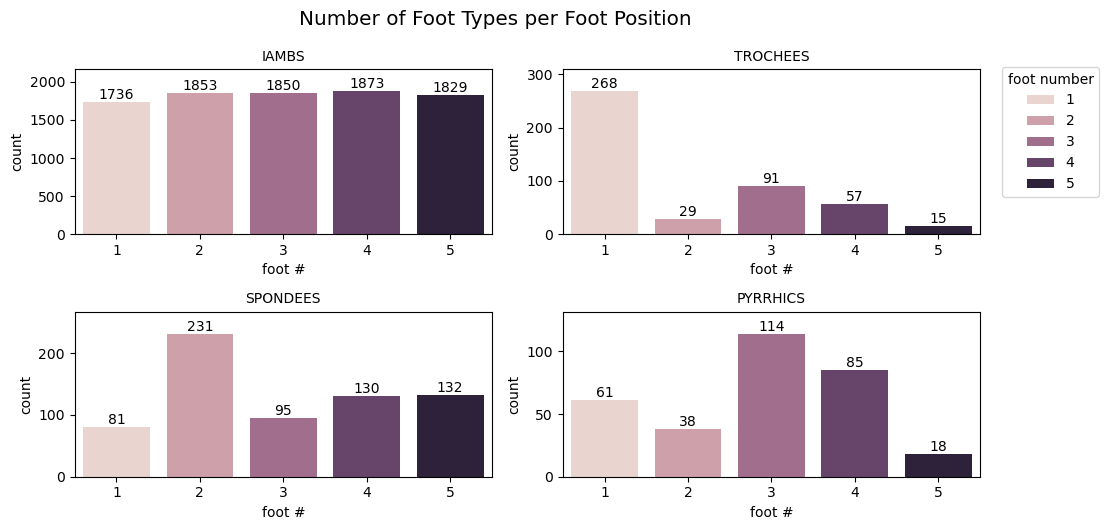

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10,5))

for ax, ft in zip(axes.flatten(), FOOT_TYPES_DISYL):
    getlegend = True if ft == FOOT_TYPES_DISYL[0] else False
    sns.barplot(
        ax = ax,
        data = fc_per_index,
        x = 'foot #',
        y = ft, 
        hue = 'foot #',
        orient = 'vertical',
        legend=getlegend
    )
    if getlegend:
        ax.get_legend().remove()
    for container in ax.containers:
        ax.bar_label(container)
    # modify y-limits of graph to show all labels
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] + (ylim[1] - ylim[0])/10)
    ax.set_title(f'{ft.upper()}S', size='medium')
    ax.set_ylabel('count')

fig.tight_layout()
fig.suptitle('Number of Foot Types per Foot Position', y=1.05, size='x-large');
fig.legend(title='foot number')
sns.move_legend(fig, 'upper left', bbox_to_anchor=(1, 0.95))

This graph confirms our conclusion that the differences between iamb frequencies are not significant, whereas at least some of the differences between the trochee, spondee, and pyrrhic frequencies are significant.

Based on visual inspection, we can tentatively conclude the following:
* Trochees are most likely to occur in the first foot and least likely to occur in the second and fifth feet.
* Spondees are most likely to occur in the second foot and least likely to occur in the first and third feet.
* Pyrrhics are most likely to occur in the third foot and least likely to occur in the fifth foot.

### Irregularities per Line Number

Next, we will analyze whether irregularities are more likely to occur in certain lines of a sonnet than in others. For example, are the concluding lines of quatrains (lines 4, 8, and 12) more or less likely to be irregular than the other lines of those quatrains (lines 1-3, 5-7, and 9-11)?

Before we can determine this, however, we must determine what exactly counts as an irregularity. For the purposes of this analysis, we will define an irregular line as a line in which the proportion of iambs is smaller than some boundary proportion $b$. We use proportions rather than counts because not all of the sonnets are in pentameter (specifically, Sonnet 145 is in tetrameter).

First, we define functions that will enable us to count how many irregularities occur in each line position in the entire corpus. These functions will take a specific value of $b$ and then calculate the counts of irregularities for each line position based on that value. (These functions also enable us to define a line that is not pentameter as irregular, but we will not be enforcing this distinction in this analysis.)

In [39]:
def count_foot_types_per_line(line, prop = False):
    counts = {f: 0 for f in FOOT_TYPES}
    n = 0
    for i, foot in enumerate(line):
        ft = classify_foot(foot)
        counts[ft] += 1
        n += 1
    # adjust counts to be proportions
    if prop:
        counts = {k: v/n for k,v in counts.items()}
    return counts

def get_irreg_line_counts(boundary, enforce_pentameter=False):
    irreg_line_counts = [0 for i in range(14)]
    for sonnet in scansions:
        for i, line in enumerate(sonnet):
            fp = count_foot_types_per_line(line, prop=True)
            if (enforce_pentameter and len(line) < 5) or fp['iamb'] < boundary:
                irreg_line_counts[i] += 1
    irreg_line_counts = pd.DataFrame(irreg_line_counts, index=[i for i in range(14)], columns=['counts'])
    irreg_line_counts['line #'] = irreg_line_counts.index + 1
    irreg_line_counts['stanza position'] = irreg_line_counts.index % 4 + 1
    return irreg_line_counts

To get an idea of how the choice of $b$ affects the irregularity counts, we will compare results for four different values of $b$. These values of $b$ will define an irregular line as one in which iambs make up less than $\frac{2}{5}$, $\frac{3}{5}$, $\frac{4}{5}$, and $\frac{5}{5}$ of the feet in that line, respectively.

We then visualize the resulting counts using bar graphs. Each line number has its own bar showing the irregularity count for that position. We also color-code the bars to represent each line's position in its stanza (first, second, third, or fourth line in a quatrain, or first or second line in a couplet).

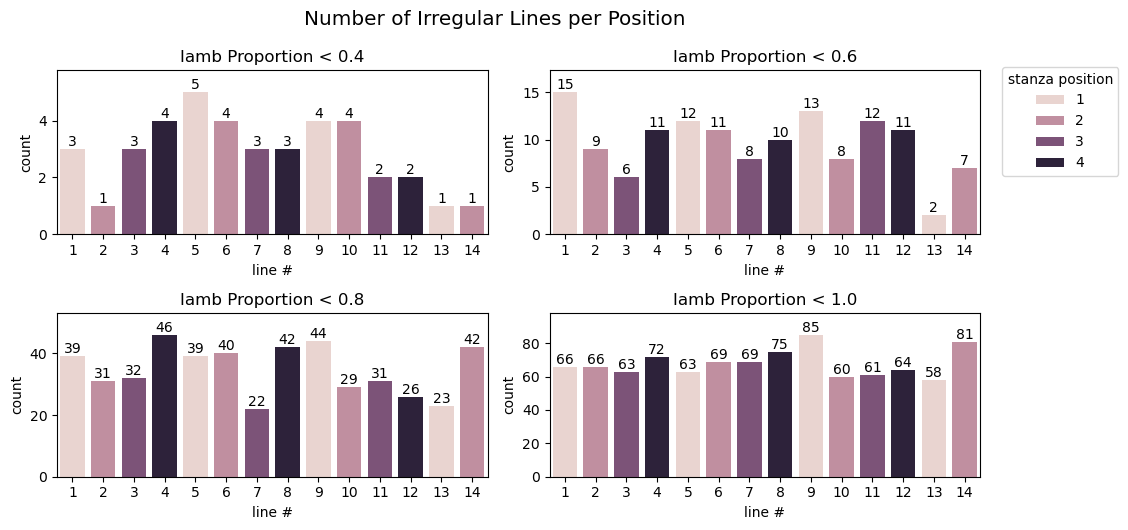

In [40]:
enforce_pentameter = False

boundaries = [0.4, 0.6, 0.8, 1.0]

irreg_tables = []

fig, axes = plt.subplots(2, 2, figsize=(10,5))

for ax, (i, boundary) in zip(axes.flatten(), enumerate(boundaries)):
    irreg_line_counts = get_irreg_line_counts(boundary, enforce_pentameter)
    irreg_tables.append(irreg_line_counts)
    getlegend = True if boundary == boundaries[0] else False
    sns.barplot(
        ax = ax,
        data = irreg_line_counts,
        x = 'line #',
        y = 'counts',
        hue = 'stanza position',
        legend=getlegend,
    );
    if getlegend:
        ax.get_legend().remove()
    for container in ax.containers:
        ax.bar_label(container)
    
    # modify y-limits of graph to show all labels
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] + (ylim[1] - ylim[0])/10)
    ax.set_title(f'{ft.upper()}S', size='medium')
    ax.set_ylabel('count')

    ax.set_title(f'Iamb Proportion < {boundary:.1f}')
#sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.01, 1.01))
fig.tight_layout()
fig.suptitle('Number of Irregular Lines per Position', y=1.05, size='x-large')
fig.legend(title='stanza position')
sns.move_legend(fig, 'upper left', bbox_to_anchor=(1, 0.95))

As we can see, the counts for $b = 0.4$ and $b = 0.6$ are very small. In other words, there are relatively few lines that fit the definition of irregularity as having a proportion of iambs less than $\frac{3}{5}$. These counts may be too small for us to conduct statistical analyses, since chi-squared tests generally require a sample size of at least 5 in each category.

For each value of $b$, we can check whether the sample size is too small and then run chi-squared independence and goodness-of-fit tests on the corresponding results if it is not:

In [41]:
for boundary, table in zip(boundaries, irreg_tables):
    print(f'Statistical Tests for Iamb Proportion < {boundary:.1f}')
    sample_min = table['counts'].min()
    print(f'  * Min sample size: {sample_min} (' +
          ('too small' if sample_min < 5 else 'large enough') +
          ' for chi-squared tests)')
    if sample_min >= 5:
        print(display_pval(chisquare(table["counts"]).pvalue, '  * Chi-squared goodness-of-fit test for counts'))
        print(display_pval(
            chi2_contingency(table[["counts", "line #"]]).pvalue,
            '  * Chi-squared independence test for counts and line numbers'
        ))
        print(display_pval(
            chi2_contingency(table[["counts", "stanza position"]]).pvalue,
            '  * Chi-squared independence test for counts and stanza positions'
        ))
    print()

Statistical Tests for Iamb Proportion < 0.4
  * Min sample size: 1 (too small for chi-squared tests)

Statistical Tests for Iamb Proportion < 0.6
  * Min sample size: 2 (too small for chi-squared tests)

Statistical Tests for Iamb Proportion < 0.8
  * Min sample size: 22 (large enough for chi-squared tests)
  * Chi-squared goodness-of-fit test for counts: p-value = 0.03 (significant)
  * Chi-squared independence test for counts and line numbers: p-value = 0.00 (significant)
  * Chi-squared independence test for counts and stanza positions: p-value = 0.77 (not significant)

Statistical Tests for Iamb Proportion < 1.0
  * Min sample size: 58 (large enough for chi-squared tests)
  * Chi-squared goodness-of-fit test for counts: p-value = 0.53 (not significant)
  * Chi-squared independence test for counts and line numbers: p-value = 0.01 (significant)
  * Chi-squared independence test for counts and stanza positions: p-value = 0.89 (not significant)



As we suspected, the counts for $b = 0.4$ and $b = 0.6$ are too small for chi-squared tests. However, the counts for $b = 0.8$ and $b = 1$ are large enough, so we were able to run the tests for those values of $b$.

When we define irregularity as having a proportion of iambs less than $\frac{4}/{5}, we find that the differences between counts are statistically significant. We also find that the irregularity counts and line numbers are not independent (though we lack sufficient evidence to conclude that the irregularity counts and stanza positions are also not independent). As a result, we can conclude that some lines in a sonnet are significantly more likely to be irregular than others.

When we define irregularity as any line with a foot type other than an iamb ($b = 1$), however, we are much more limited in what we can conclude. This is likely because the counts for the different line numbers are so similar to each other. All that we can conclude is that the irregularity counts are not independent of the line positions.

Based on visual inspection of the graph for $b = 0.8$, we can make a few tentative observations (keeping in mind that the observed differences may not all be significant):
* The second and third lines of the quatrains are relatively less likely to be irregular.
* The last lines of the first and second quatrains are relatively likely to be irregular, but the last line of the third quatrain is not. Perhaps this is because the first line of the third quatrain is also relatively likely to be irregular.
* The last line of the concluding couplet is more likely to be irregular than the first line of the couplet.

### Consecutive Feet

Finally, we will analyze whether certain pairs of consecutive foot types are more likely to occur than others. For example, is a trochee more likely to be followed by an iamb or a spondee? Given the relatively low counts of feet longer than two syllables, we limit our analysis once again to the disyllabic foot types.

For all foot types $x, y$ in the set of disyllabic foot types, we count the number of occurrences of the pair $(x, y)$ in the corpus. (Note that $x$ can be equal to $y$.) The results are shown in the table below:

In [42]:
feet_types = FOOT_TYPES_DISYL
indices = {x: i for i,x in enumerate(feet_types)}
n = len(indices)

consec_counts = np.zeros((n,n))
for sonnet in scansions:
    for line in sonnet:
        current_ft = classify_foot(line[0])
        for i in range(len(line)-1):
            next_ft = classify_foot(line[i+1])
            if current_ft in indices and next_ft in indices:
                consec_counts[indices[current_ft]][indices[next_ft]] += 1
            current_ft = next_ft
cc = pd.DataFrame(consec_counts, index=feet_types, columns=feet_types)
cc

,iamb,trochee,spondee,pyrrhic
iamb,6540.0,113.0,341.0,169.0
trochee,353.0,42.0,39.0,3.0
spondee,386.0,28.0,36.0,74.0
pyrrhic,107.0,6.0,171.0,9.0


We can use a chi-squared independence test to determine whether these results are statistically significant:

In [43]:
print(display_pval(chi2_contingency(cc).pvalue, 'P-value for chi-squared independence test'))

P-value for chi-squared independence test: p-value = 0.00 (significant)


We conclude that the types of the first and second feet in the pairs are not independent. In other words, the type of a given foot depends at least in part on the type of the preceding foot.

We can also visualize the counts of foot type pairs using a heatmap:

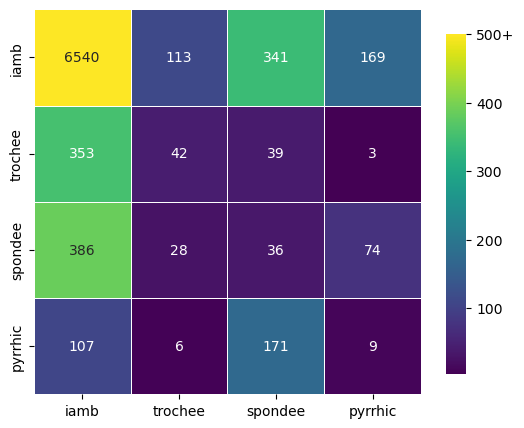

In [44]:
# set up axes
fig, ax = plt.subplots(figsize=(5,5))
cbar_ax = fig.add_axes([0.95, .15, .04, .68])

sns.heatmap(cc, annot=True, fmt='.0f', linewidth=.5, cmap='viridis', vmax=500, ax=ax, cbar_ax=cbar_ax);

# set custom vmax label in colormap legend
# (based on answer by mburke05 at https://stackoverflow.com/a/37054853, CC BY-SA 3.0 license)
original_labels = cbar_ax.get_yticklabels()
labels = [x.get_text() for x in original_labels[1:-1]] + [f'{original_labels[-1].get_text()}+']
cbar_ax.set_yticks(cbar_ax.get_yticks()[1:]);
cbar_ax.set_yticklabels(labels);

Based on visual analysis of this heatmap, we can make an interesting observation about the relationship between pyrrhics and other feet. As expected, consecutive feet are far and away most likely to consist of a pair of iambs. Since iambs are the most common foot type, they are the most likely to be the first element of a pair with any other disyllabic foot type. They are also the most likely to be the second element of a pair following a trochee or a spondee. However, they are only second most likely to follow pyrrhics, trailing slightly behind spondees (with 171 (`pyrrhic`, `spondee`) pairs compared to only 107 (`pyrrhic`, `iamb`) pairs). Perhaps this indicates a pattern in English prosody where a pair of unstressed syllables tends to be followed by a pair of stressed syllables.

## Conclusion

This project has offered a case study of how the corpus of Shakespeare's sonnets can be prepared and parsed into a form that allows for various forms of computationally aided analysis. In doing so, this project has offered both theoretical ideas and practical implementations for how to annotate, encode, and investigate poetic corpora.

Through the process of correcting the corpus, I have identified and grappled with various problems such as how to map a prosodic theory onto an actual text, how to standardize scansion marks, and how to handle cases of prosodic flexibility. Through the process of parsing and scanning the corpus, I have learned how to structure and operate on the text and scansion data while prioritizing both efficiency and comprehensibility. Finally, through the process of analyzing the corpus, I have gained insights into the ways that knowledge of poetry paired with computational techniques can reveal intriguing patterns in prosody.

This project has raised many interesting questions and made many intriguing observations about Shakespeare's sonnets. Nevertheless, further work is needed to fully explore the possibilities of this sort of computational analysis. For example, the scansion data used in this report includes information about punctuation, yet my analysis did not take this into account. Future research could remedy this omission by investigating questions about how punctuation affects prosodic patterns in poetry. As another example, this report considers Shakespeare's sonnets in isolation rather than situating them in their wider context. It would be interesting to compare patterns in Shakespeare's sonnets to patterns in other sonnet sequences such as Sir Philip Sidney's *Astrophil and Stella* or Edmund Spenser's *Amoretti*.

Parts of the process detailed in this report, such as the manual correction of the corpus, may not be easily generalizable to other contexts, since they were tailored so closely to the unique problems presented by this particular corpus. However, some of the other sections of this report may provide valuable ideas and implementations for how to conduct computational analyses on other poetic corpora. In particular, it is my hope that my suggestions regarding the structure and encoding of both text and scansion data may prove useful for other projects.